#  Ensemble Development

## Import of Packages and Data

First, we import the proper modules and our data.  Pyplot is used to make the scatterplot and plot a regression line.  Numpy is used because ScikitLearn's machine learning algorithms require the use of numpy arrays.  Pandas allows us to get the .csv file as a dataframe.  For now, we are just working with the "abalone" dataset from the KEEL database.  We are attempting to predict an abalone snail's age (number of rings) through different factors.  Below, we import some packages we need and and the data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

abalone = pd.read_csv("abalone.csv")

abalone.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


The following block imports some of the functions we'll be using from the ScikitLearn modules.  Our regression algorithms come from "sklearn.linear_model," and the MSE function comes from "sklearn.metrics."

In [2]:
#  Sklearn modules
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error

Below, we are just playing with a single algorithm to see how one is used.

In [3]:
#  Single Regression

abalone_vars = np.array(abalone.iloc[:,1:-1])
abalone_age = np.array(abalone.iloc[:,-1])

lin_reg = LinearRegression()    #  This line creates an instance of linear regression model ready to be trained.
lin_reg.fit(abalone_vars[:,5].reshape(-1,1), abalone_age)  #  This is the training line.
lin_reg.intercept_, lin_reg.coef_  #  This is how we access the intercept and coefficient parameters
#abalone_vars.iloc[:,5].reshape(-1,1)

(7.25755961420464, array([14.82111069]))

Here, we are plotting the trained regression line and a scatterplot of one of the factors vs age.

7.25755961420464 14.82111069366904


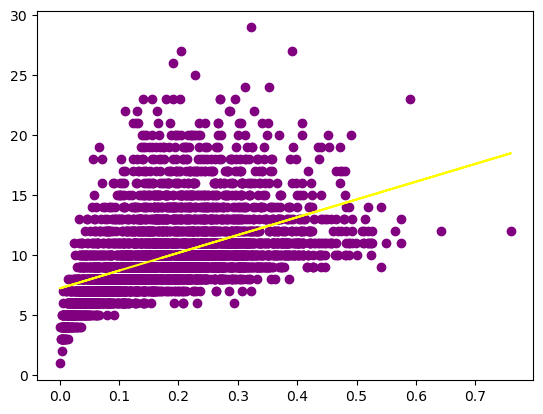

In [4]:
b, m = lin_reg.intercept_, lin_reg.coef_.item()
print(b, m)
plt.scatter(abalone_vars[:,5], abalone_age, color="purple")
plt.plot(abalone_vars[:,5], m*abalone_vars[:,5]+b, color="yellow")

## Preparing for the Ensemble

We are getting ready to construct the ensemble.  Here, we are making available some regression algorithms available for the ensemble.

In [5]:
#  Some regression algorithms available to the ensemble coming up.  These
#  will be stored in the list "predictors" and accessed through the list's
#  indices.
predictors = [LinearRegression(),                  # Option 0
              Lasso(alpha=0.1),                    # Option 1
              ElasticNet(alpha=0.1, l1_ratio=0.5), # Option 2
              Ridge(alpha=1, solver="cholesky"),   # Option 3
              DecisionTreeClassifier(max_depth=1), # Option 4
              SVR()]                               # Option 5

Here, we are implementing a function that will partition the data into training and test sets.  The test_ratio argument allows us to specify how much of the data to leave asside for testing.

In [8]:
#  Data split from Geron's "Hands-on Machine Learning with Scikit-Learn,
#  Keras & Tensorflow"
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(abalone, 0.2)

#train_set.shape, test_set.shape

## Construction of the Ensemble

Here is the implementation of an algorithm similar to Algorithm 1 in "Machine Learning Ensemble for Wind Power Prediction" by J. Heinermann and O. Kramer (p. 8).

In [23]:
#  Splitting the data into training and test sets
#train_set, test_set = split_train_test(abalone, 0.2)

#  Separating factors from response (labels)
#X_vars = train_set.iloc[:,1:-1]
#X_labels = train_set.iloc[:,-1]

#  These lists will hold the trained models and calculated weights, resp.
weak_preds = []
weights = []

#  Here is the bulk of the implementation of Algorithm 1 in the Heinermann, Kramer paper
#Y = X_labels.to_numpy()
#X = X_vars.to_numpy()
for i in range(0,4):
    #  Sampling of Data
    train_set, test_set = split_train_test(abalone, 0.2)
    X_vars = train_set.iloc[:,1:-1]
    X_labels = train_set.iloc[:,-1]
    Y = X_labels.to_numpy()
    X = X_vars.to_numpy()
    #  Model training
    weak_lin_reg = predictors[i]      #<-------------------------------------------------------  Change number to desired option from above.  Set to i for hetero. ens.
                                                                                            #    If i is constant, ensemble is homogeneous.
    weak_lin_reg.fit(X, Y)
    weak_preds.append(weak_lin_reg)
    weights.append(1 / mean_squared_error(weak_lin_reg.predict(test_set.iloc[:,1:-1].to_numpy()), 
                                          test_set.iloc[:,-1].to_numpy()))

So now our trained predictors are in `weak_preds` and our calculated weights are in `weights`, which are accessed as follows:

In [24]:
#  Printing the calculated weights, w_i, in the algorithm
for i in range(0,4):
    print(weights[i])

0.18819773164203035
0.13627663451317848
0.13687722785319983
0.20896573176979483


Below, we calculate the aggregate prediction using the predictions of the weak predictors and their respective weights.  We first generate a random new observation whose factor ranges fit in with our data's ranges.  We then make predictions with all of our weak predictors.  After, we calculate the dot product of the weights and the prediction and normalize the result with the sum of the weights.  This is the ensemble prediction given on p. 9 of the Heinermann, Kramer paper.

In [25]:
import random

In [26]:
X_new = pd.DataFrame([[random.uniform(0.075,0.815),  #  Length
                       random.uniform(0.055,0.65),   #  Diameter
                       random.uniform(0.0,1.13),     #  Height 
                       random.uniform(0.0020,2.8255),#  Whole Weight 
                       random.uniform(0.0010,1.488), #  Shucked_weight
                       random.uniform(0.0005,0.76),  #  Viscera_weight
                       random.uniform(0.0015,1.005)]]#  Shell weight
                    ).to_numpy()
X_new.reshape(1,-1)

array([[0.73872656, 0.61165136, 0.8966932 , 0.43996802, 0.98215286,
        0.55278684, 0.95291301]])

In [27]:
X_new

array([[0.73872656, 0.61165136, 0.8966932 , 0.43996802, 0.98215286,
        0.55278684, 0.95291301]])

In [28]:
predictions = []
for p in weak_preds:
    predictions.append(p.predict(X_new).item())
                    
predictions   # To view each prediction

[14.50483687888283, 8.745708795834243, 9.720447450692077, 10.201420462663535]

The following cell is the final prediction from the ensemble.

In [29]:
#  Numerator
weights2 = np.array(weights)
numerator = sum(weights2 * predictions)

#  Denominator
denominator = sum(weights)

#  Prediction of the ensemble
ens_pred = numerator/denominator
ens_pred

11.015481874371964